<a href="https://colab.research.google.com/github/Dollie1330/daa3-graph-algorithms/blob/main/DAA_LAB_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Colab: run this first
!pip install -q memory_profiler  # optional; tracemalloc fallback used

import time, random, tracemalloc, math, heapq, os
import matplotlib.pyplot as plt
import numpy as np
from collections import deque, defaultdict, namedtuple
plt.rcParams['figure.figsize'] = (9,5)
random.seed(0)
os.makedirs("images", exist_ok=True)


In [2]:
# Use median of repeats for stable timing
def time_it(func, *args, repeats=3, **kwargs):
    times = []
    result = None
    for _ in range(repeats):
        t0 = time.perf_counter()
        result = func(*args, **kwargs)
        t1 = time.perf_counter()
        times.append(t1 - t0)
    times.sort()
    return times[len(times)//2], result

# Memory measurement with tracemalloc (works in Colab)
def mem_it(func, *args, **kwargs):
    tracemalloc.start()
    func(*args, **kwargs)
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    return peak / (1024*1024)  # MB


In [3]:
# Graph as adjacency list (undirected)
class SocialGraph:
    def __init__(self):
        self.adj = defaultdict(set)

    def add_edge(self, u, v):
        self.adj[u].add(v)
        self.adj[v].add(u)

    def add_user(self, u):
        self.adj.setdefault(u, set())

    def neighbors(self, u):
        return self.adj.get(u, set())

    def users(self):
        return list(self.adj.keys())

def suggest_friends_bfs(graph: SocialGraph, user, max_depth=2):
    """
    BFS to depth 2 (friends-of-friends). Return suggestions sorted by mutual count.
    Excludes existing friends and the user themself.
    """
    if user not in graph.adj:
        return []

    visited = set([user])
    q = deque([(user,0)])
    # collect candidate -> number of mutual friends
    candidate_counts = defaultdict(int)

    # Track direct friends for exclusion & mutual calculation
    direct_friends = set(graph.neighbors(user))

    while q:
        node, depth = q.popleft()
        if depth >= max_depth:
            continue
        for nbr in graph.neighbors(node):
            if nbr == user:
                continue
            if depth == 0:
                # neighbors of user -> direct friends: add to queue
                pass
            if nbr not in visited:
                visited.add(nbr)
                q.append((nbr, depth + 1))
            # If we're exploring from a direct friend and the neighbor is not direct friend and not user, it's a friend-of-friend
            # We count mutual friends by intersection later; here we can just mark potential candidates
    # Build suggestion counts using mutual friend counts
    for candidate in graph.users():
        if candidate == user or candidate in direct_friends:
            continue
        # mutual friends: intersection size
        mutual = len(direct_friends.intersection(graph.neighbors(candidate)))
        if mutual > 0:
            candidate_counts[candidate] = mutual
    # Sort by mutual desc then name
    suggestions = sorted(candidate_counts.items(), key=lambda x: (-x[1], x[0]))
    return suggestions  # list of (candidate, mutual_count)


All users: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I']
Neighbors of A: ['B', 'C']
Suggestions for A (candidate, mutual friends): [('D', 2), ('E', 2)]
n=100 -> median time 0.000084s
n=500 -> median time 0.000356s
n=1000 -> median time 0.000683s
n=2000 -> median time 0.001325s


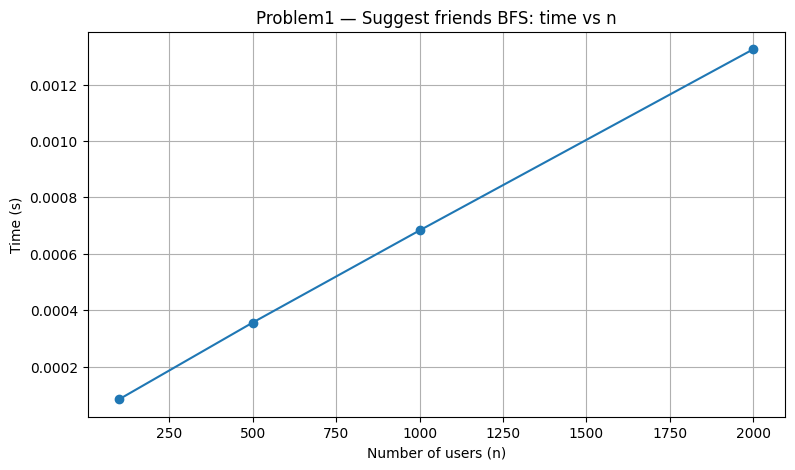

In [4]:
# Build a sample social graph
g = SocialGraph()
edges = [
    ("A","B"),("A","C"),("B","D"),("C","D"),("C","E"),("D","F"),
    ("E","G"),("F","G"),("H","I"),("G","I"),("B","E")
]
for u,v in edges:
    g.add_edge(u,v)

print("All users:", sorted(g.users()))
print("Neighbors of A:", sorted(g.neighbors("A")))

sugg = suggest_friends_bfs(g, "A")
print("Suggestions for A (candidate, mutual friends):", sugg)

# Small experiment: expand graph randomly and measure time vs nodes
def gen_random_social(n, avg_deg=3):
    G = SocialGraph()
    # create nodes
    nodes = [f"u{i}" for i in range(n)]
    for u in nodes:
        G.add_user(u)
    # add random edges with average degree
    for u in nodes:
        deg = random.randint(max(1,avg_deg-1), avg_deg+1)
        for _ in range(deg):
            v = random.choice(nodes)
            if v != u:
                G.add_edge(u,v)
    return G

sizes = [100, 500, 1000, 2000]
times = []
for s in sizes:
    Gr = gen_random_social(s, avg_deg=4)
    t, _ = time_it(suggest_friends_bfs, Gr, "u0", 2, repeats=3)
    times.append(t)
    print(f"n={s} -> median time {t:.6f}s")
plt.plot(sizes, times, marker='o')
plt.xlabel("Number of users (n)")
plt.ylabel("Time (s)")
plt.title("Problem1 — Suggest friends BFS: time vs n")
plt.grid(True)
plt.savefig("images/problem1_bfs_time_vs_n.png")
plt.show()


In [5]:
# Edge list graph directed with weights
class WeightedGraph:
    def __init__(self):
        self.edges = []  # (u, v, w)
        self.nodes = set()

    def add_edge(self, u, v, w):
        self.edges.append((u,v,w))
        self.nodes.add(u); self.nodes.add(v)

    def vertices(self):
        return list(self.nodes)

def bellman_ford(graph: WeightedGraph, source):
    # initialize
    nodes = list(graph.nodes)
    dist = {v: math.inf for v in nodes}
    pred = {v: None for v in nodes}
    if source not in graph.nodes:
        return None, None, "Source not in graph"
    dist[source] = 0

    V = len(nodes)
    # relax edges V-1 times
    for _ in range(V-1):
        updated = False
        for u,v,w in graph.edges:
            if dist[u] + w < dist[v]:
                dist[v] = dist[u] + w
                pred[v] = u
                updated = True
        if not updated:
            break

    # check for negative cycles
    for u,v,w in graph.edges:
        if dist[u] + w < dist[v]:
            return dist, pred, "Negative weight cycle detected"

    return dist, pred, None


Distances: {'B': 2, 'A': 4, 'C': -2, 'S': 0, 'D': 1}
Error: None
G2 detection result: Negative weight cycle detected
V=50, E=200 -> time 0.002671s
V=100, E=500 -> time 0.012339s
V=200, E=1000 -> time 0.038793s


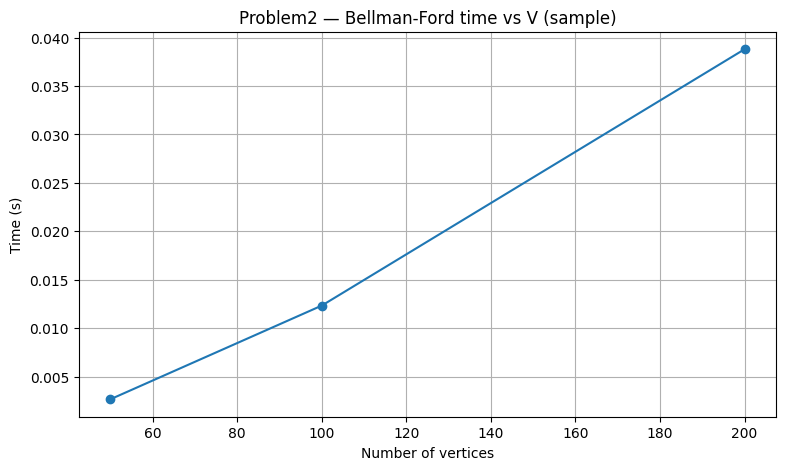

In [6]:
# sample directed graph with a negative weight edge (but no cycle)
G = WeightedGraph()
G.add_edge("S","A",4)
G.add_edge("S","B",5)
G.add_edge("A","C",-6)
G.add_edge("B","C",2)
G.add_edge("C","D",3)
G.add_edge("D","B",1)  # create possible cycle if negative

dist, pred, error = bellman_ford(G, "S")
print("Distances:", dist)
print("Error:", error)

# create graph including a negative cycle to test detection
G2 = WeightedGraph()
G2.add_edge("1","2",1)
G2.add_edge("2","3",-2)
G2.add_edge("3","1",-2)  # negative cycle
d2, p2, e2 = bellman_ford(G2, "1")
print("G2 detection result:", e2)

# Experiment: scale edges/nodes and time
def gen_random_weighted(n_nodes, n_edges, weight_range=(-10,20), allow_negative=True):
    g = WeightedGraph()
    nodes = [f"v{i}" for i in range(n_nodes)]
    for _ in range(n_edges):
        u = random.choice(nodes); v = random.choice(nodes)
        # avoid self loops for simplicity
        if u==v: continue
        w = random.randint(weight_range[0], weight_range[1]) if allow_negative else random.randint(max(0,weight_range[0]), weight_range[1])
        g.add_edge(u,v,w)
    return g

sizes = [(50,200),(100,500),(200,1000)]
times=[]
for n,e in sizes:
    g = gen_random_weighted(n,e)
    t,_ = time_it(bellman_ford, g, "v0", repeats=3)
    times.append(t)
    print(f"V={n}, E={e} -> time {t:.6f}s")
plt.plot([s[0] for s in sizes], times, marker='o')
plt.title("Problem2 — Bellman-Ford time vs V (sample)")
plt.xlabel("Number of vertices")
plt.ylabel("Time (s)")
plt.grid(True)
plt.savefig("images/problem2_bellman_time.png")
plt.show()


In [7]:
def dijkstra(adj_list, source):
    """
    adj_list: dict node -> list of (neighbor, weight)
    returns: dist dict, prev dict
    """
    dist = {v: math.inf for v in adj_list}
    prev = {v: None for v in adj_list}
    if source not in adj_list:
        return None, None
    dist[source] = 0
    heap = [(0, source)]
    visited = set()
    while heap:
        d,u = heapq.heappop(heap)
        if u in visited:
            continue
        visited.add(u)
        for v,w in adj_list[u]:
            nd = d + w
            if nd < dist[v]:
                dist[v] = nd
                prev[v] = u
                heapq.heappush(heap, (nd, v))
    return dist, prev


Dijkstra distances: {'S': 0, 'A': 2, 'B': 4, 'C': 5, 'D': 8}
n=100 -> median time 0.000200s
n=500 -> median time 0.000739s
n=1000 -> median time 0.001737s
n=2000 -> median time 0.004070s


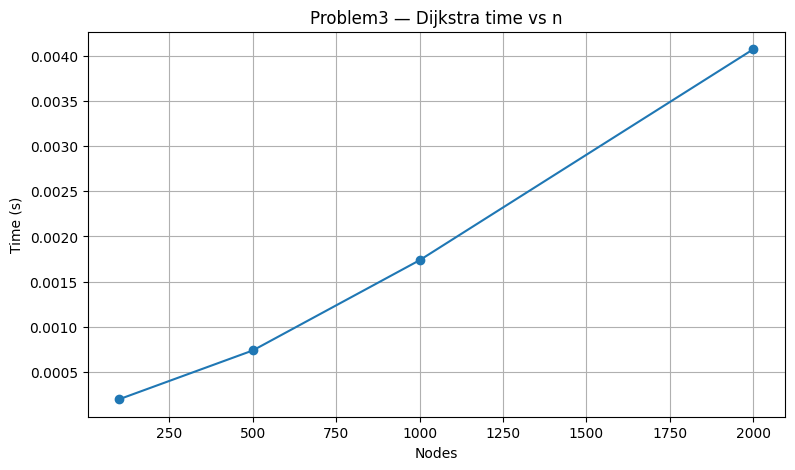

In [8]:
# Sample small city graph (positive weights)
city = {
    "S":[("A",2),("B",5)],
    "A":[("S",2),("B",2),("C",4)],
    "B":[("S",5),("A",2),("C",1)],
    "C":[("A",4),("B",1),("D",3)],
    "D":[("C",3)]
}
dist, prev = dijkstra(city, "S")
print("Dijkstra distances:", dist)

# Generate random sparse graph as adjacency list for experiments
def gen_random_positive_graph(n_nodes, avg_deg=3, max_w=20):
    nodes = [f"n{i}" for i in range(n_nodes)]
    adj = {u:[] for u in nodes}
    for u in nodes:
        deg = random.randint(max(1, avg_deg-1), avg_deg+1)
        for _ in range(deg):
            v = random.choice(nodes)
            if v==u: continue
            w = random.randint(1, max_w)
            adj[u].append((v,w))
    return adj

sizes = [100, 500, 1000, 2000]
times=[]
for s in sizes:
    adj = gen_random_positive_graph(s, avg_deg=4, max_w=50)
    t,_ = time_it(dijkstra, adj, "n0", repeats=3)
    times.append(t)
    print(f"n={s} -> median time {t:.6f}s")
plt.plot(sizes, times, marker='o')
plt.title("Problem3 — Dijkstra time vs n")
plt.xlabel("Nodes")
plt.ylabel("Time (s)")
plt.grid(True)
plt.savefig("images/problem3_dijkstra_time.png")
plt.show()


In [9]:
# Union-Find
class UnionFind:
    def __init__(self):
        self.parent = {}
        self.rank = {}

    def make_set(self, x):
        if x not in self.parent:
            self.parent[x] = x
            self.rank[x] = 0

    def find(self, x):
        if self.parent[x] != x:
            self.parent[x] = self.find(self.parent[x])
        return self.parent[x]

    def union(self, x, y):
        rx, ry = self.find(x), self.find(y)
        if rx == ry: return False
        if self.rank[rx] < self.rank[ry]:
            self.parent[rx] = ry
        else:
            self.parent[ry] = rx
            if self.rank[rx] == self.rank[ry]:
                self.rank[rx] += 1
        return True

def kruskal(nodes, edges):
    """
    nodes: iterable of node labels
    edges: list of (u, v, w)
    returns: (mst_edges, total_cost)
    """
    uf = UnionFind()
    for n in nodes:
        uf.make_set(n)
    edges_sorted = sorted(edges, key=lambda x: x[2])
    mst=[]
    cost=0
    for u,v,w in edges_sorted:
        if uf.union(u,v):
            mst.append((u,v,w))
            cost += w
    return mst, cost

# Prim's algorithm (using heap), adjacency list format
def prim(adj):
    start = next(iter(adj))
    visited = set([start])
    heap = []
    for v,w in adj[start]:
        heapq.heappush(heap, (w, start, v))
    mst=[]
    total=0
    while heap and len(visited) < len(adj):
        w,u,v = heapq.heappop(heap)
        if v in visited:
            continue
        visited.add(v)
        mst.append((u,v,w))
        total += w
        for nbr,wt in adj[v]:
            if nbr not in visited:
                heapq.heappush(heap, (wt, v, nbr))
    return mst, total


Kruskal MST edges: [('A', 'B', 1), ('B', 'C', 1), ('C', 'E', 2), ('B', 'D', 4)] Total cost: 8
Prim MST edges: [('A', 'B', 1), ('B', 'C', 1), ('C', 'E', 2), ('B', 'D', 4)] Total cost: 8
n=50 -> Kruskal 0.000100s, Prim 0.000068s
n=100 -> Kruskal 0.000313s, Prim 0.000263s
n=200 -> Kruskal 0.000894s, Prim 0.001102s


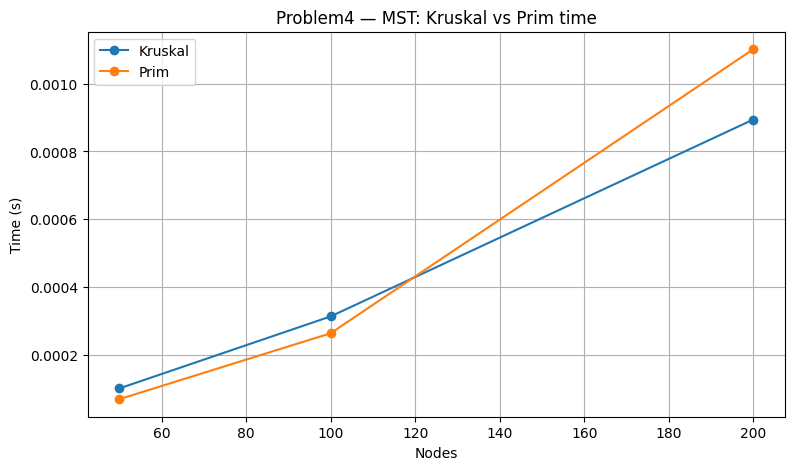

In [10]:
# small sample graph (undirected)
nodes = ["A","B","C","D","E"]
edges = [
    ("A","B",1),("A","C",3),("B","C",1),("B","D",4),("C","E",2),("D","E",5)
]
mst_edges, total = kruskal(nodes, edges)
print("Kruskal MST edges:", mst_edges, "Total cost:", total)

# For Prim, build adjacency list
adj = {n:[] for n in nodes}
for u,v,w in edges:
    adj[u].append((v,w))
    adj[v].append((u,w))
mst_p, total_p = prim(adj)
print("Prim MST edges:", mst_p, "Total cost:", total_p)

# Experiment: random graph (complete-ish or random sparse)
def gen_random_connected_graph(n_nodes, prob=0.1, max_w=100):
    nodes = [f"v{i}" for i in range(n_nodes)]
    edges=[]
    # ensure connectivity by chain
    for i in range(n_nodes-1):
        w = random.randint(1,max_w)
        edges.append((nodes[i], nodes[i+1], w))
    # add random edges
    for i in range(n_nodes):
        for j in range(i+2, n_nodes):
            if random.random() < prob:
                edges.append((nodes[i], nodes[j], random.randint(1,max_w)))
    # build adjacency for prim
    adj = {n:[] for n in nodes}
    for u,v,w in edges:
        adj[u].append((v,w)); adj[v].append((u,w))
    return nodes, edges, adj

sizes = [50, 100, 200]
times_kr = []
times_pr = []
for s in sizes:
    ns, es, adjg = gen_random_connected_graph(s, prob=0.02, max_w=200)
    t1,_ = time_it(kruskal, ns, es, repeats=1)
    t2,_ = time_it(prim, adjg, repeats=1)
    times_kr.append(t1); times_pr.append(t2)
    print(f"n={s} -> Kruskal {t1:.6f}s, Prim {t2:.6f}s")
plt.plot(sizes, times_kr, marker='o', label='Kruskal')
plt.plot(sizes, times_pr, marker='o', label='Prim')
plt.xlabel("Nodes")
plt.ylabel("Time (s)")
plt.title("Problem4 — MST: Kruskal vs Prim time")
plt.legend(); plt.grid(True)
plt.savefig("images/problem4_mst_time.png")
plt.show()


In [11]:
print("SUMMARY — All images saved into /images:")
for f in sorted(os.listdir("images")):
    print(" -", f)

print("\nNotes:")
print("- Problem1 uses BFS to find friends-of-friends. Complexity O(V+E).")
print("- Problem2 uses Bellman-Ford: O(V*E) and detects negative cycles.")
print("- Problem3 uses Dijkstra with min-heap: O(E log V) for sparse graphs.")
print("- Problem4 implements Kruskal (Union-Find) and Prim; MST cost gives min cable length.")


SUMMARY — All images saved into /images:
 - problem1_bfs_time_vs_n.png
 - problem2_bellman_time.png
 - problem3_dijkstra_time.png
 - problem4_mst_time.png

Notes:
- Problem1 uses BFS to find friends-of-friends. Complexity O(V+E).
- Problem2 uses Bellman-Ford: O(V*E) and detects negative cycles.
- Problem3 uses Dijkstra with min-heap: O(E log V) for sparse graphs.
- Problem4 implements Kruskal (Union-Find) and Prim; MST cost gives min cable length.
